In [4]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

## Calculating Wind Veer and Shear

In [7]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff

def calculate_wind_veer(file_paths, start_date=None, end_date=None):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
        start_date (datetime): Optional start date as a datetime object.
        end_date (datetime): Optional end date as a datetime object.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []

    print("Start Date: ", start_date)
    print("End Date: ", end_date)

    # Convert start_date and end_date to UTC (if need be)
    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(file_path)
        
        # Load netCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values  # Quality control variable for wind speed
        azim = ds['Azim'].values  # Wind direction (vector-averaged) in degrees
        qc_azim = ds['qc_Azim'].values  # Quality control variable for wind direction
        
        times = pd.to_datetime(time_var.values, utc=True)  # Convert to datetime
        
        # Filter by date range if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
            azim = azim[valid_idx, :]
            qc_azim = qc_azim[valid_idx, :]

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        # Calculate wind veer (difference in wind direction between 140m and 40m)
        wind_direction_40m = azim[:, idx_40m]  # Wind direction at 40m
        wind_direction_140m = azim[:, idx_140m]  # Wind direction at 140m

        
        # Calculate wind shear (difference in wind speed with height, normalized over vertical distance)
        height_diff = height_var[idx_140m] - height_var[idx_40m]  # Vertical distance between 40m and 140m
        wind_speed_40m = vhm[:, idx_40m]  # Wind speed at 40m
        wind_speed_140m = vhm[:, idx_140m]  # Wind speed at 140m        

        # Compute wind veer as the shortest rotational path between the two heights
        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        
        wind_veer =  difference / height_diff
        
        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]

        # Append data to lists
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)



    return all_times, all_wind_veer

## Wind Shear using Power Law

In [10]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)

        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        
        #print(f"Height variable: {height_var}")
        #print(f"Vhm shape: {vhm.shape}, QC shape: {qc_vhm.shape}")

        times = pd.to_datetime(time_var.values, utc=True)
        
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            #print(f"Valid time indices: {np.sum(valid_idx)}")
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
        
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            print(f"Available heights: {height_var}")
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        idx_40m, idx_140m = idx_40m[0], idx_140m[0]
        #print(f"Indices for 40m: {idx_40m}, 140m: {idx_140m}")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0)
        #print(f"Valid mask has {np.sum(valid_mask)} valid entries")
        
        times = times[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]

        if len(times) == 0:
            #print("on file: ", file_path)
            #print("No valid data points after filtering by QC.")
            continue
        
        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        #print(f"Calculated alpha values: {alpha[:5]} (showing first 5)")
        all_times.extend(times)
        all_alpha.extend(alpha)

    return all_times, all_alpha


### Wind Veer Plotting 

In [13]:
def plot_wind_veer(times, wind_veer):
    """
    Plot wind veer over time.
    
    Parameters:
        times (list): List of datetime objects.
        wind_veer (list): List of wind veer values.
    """
    # Debugging: Check the data before plotting
    if len(times) == 0 or len(wind_veer) == 0:
        print("Error: No data to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(times, wind_veer, label="Wind Veer (140m - 40m)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Wind Veer (m/s)")
    plt.title("Wind Veer Over Time")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

## File Collection

In [30]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        # CHANGEME below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site C1A
        if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]

# CHANGEME Usage for Site A2
#directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA2'
# CHANGEME Usage for Site C1a
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'

start_date = '20221111'  # Replace with any start date
end_date = '20231106'    # Replace with any end date

matching_files = filter_files_by_date(directory, start_date, end_date)
#print("Matching files:")
#for file_path in matching_files:
#    print(file_path)

### Set Times Below - run each time choose new time frame

In [22]:
start_date = datetime(2022, 11, 11)
end_date = datetime(2023, 11, 6)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

Start Date:  2022-11-11 00:00:00
End Date:  2023-11-06 00:00:00


## Annual C1A

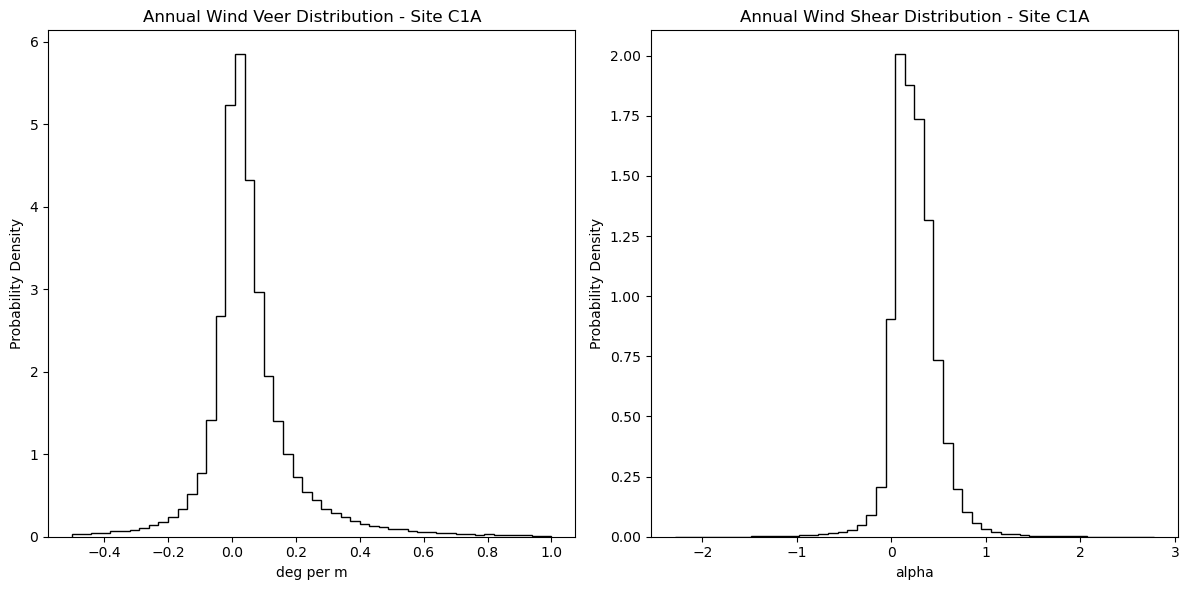

In [133]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step',range=[-0.5,1.0], density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site C1A')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site C1A')

# Show the plot
plt.tight_layout()
plt.show()


## Annual A2

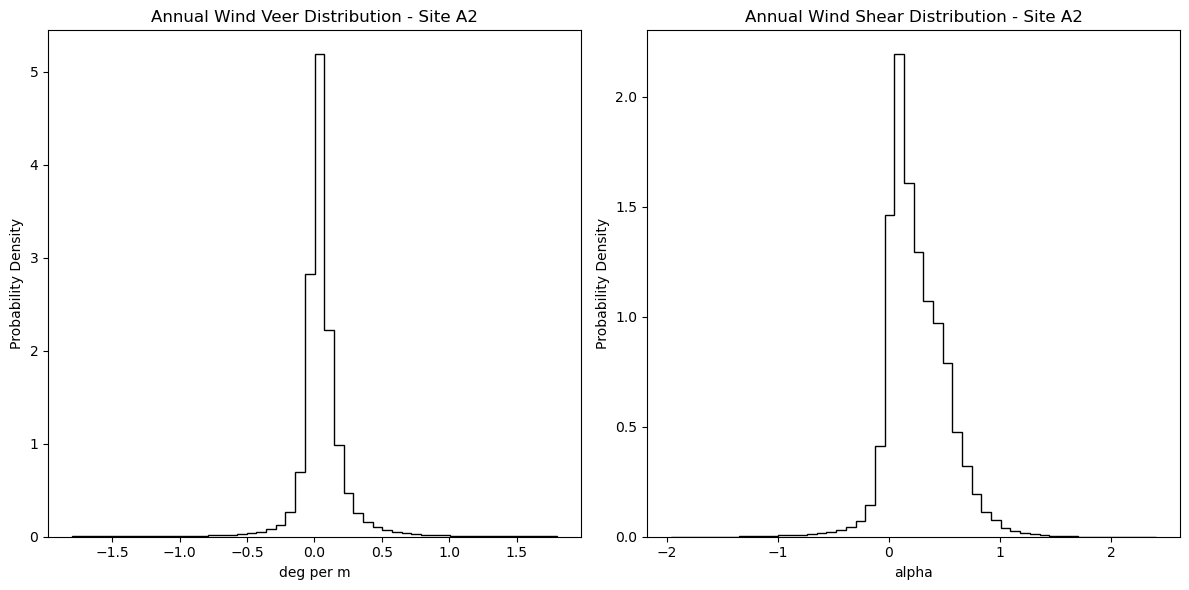

In [1411]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step', density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site A2')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site A2')

# Show the plot
plt.tight_layout()
plt.show()


In [110]:
#leaving this here for reference, daily avgs no error bars no histograms
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, wind_veer, and wind_shear match
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping by time_of_day to compute the mean for each hour
    df_grouped = df.groupby('time_of_day').agg({
        'wind_veer': 'mean',
        'wind_shear': 'mean'
    }).reindex(all_times, fill_value=np.nan)

    # Normalize wind shear to match the scale of wind veer for visualization
    wind_shear_normalized = df_grouped['wind_shear'] / df_grouped['wind_shear'].max() * df_grouped['wind_veer'].max()

    # Plotting the data
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(df_grouped.index, df_grouped['wind_veer'], color='blue', alpha=0.6, label='Wind Veer')
    ax.plot(df_grouped.index, wind_shear_normalized, color='red', marker='o', linestyle='-', label='Wind Shear')

    # Labels and title
    ax.set_xlabel('Time of Day (UTC)', fontsize=12)
    ax.set_ylabel('Wind Veer (deg)', fontsize=12)
    ax.set_title(f'Daily Average Wind Veer and Shear: {start_date.date()} to {end_date.date()}', fontsize=14)

    # Add a legend
    ax.legend()

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')

    # Adjust the y-axis range to ensure both plots fit well
    ax.set_ylim(0, max(df_grouped['wind_veer'].max(), wind_shear_normalized.max()) * 1.1)

    plt.tight_layout()
    plt.show()
'''

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, wind_veer, and wind_shear match
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
    daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)
    daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

    # Find times and values of max veer and shear
    max_veer_value = daily_avg_veer.max()
    max_veer_time = daily_avg_veer.idxmax()

    max_shear_value = daily_avg_shear.max()
    max_shear_time = daily_avg_shear.idxmax()

    print(f"Maximum Wind Veer: {max_veer_value} deg/m at {max_veer_time}")
    print(f"Maximum Wind Shear: {max_shear_value} m/s/m at {max_shear_time}")

    fig, ax1 = plt.subplots(figsize=(12, 6))
    '''
    # Plot Wind Veer with error bars (blue) on top of histogram
    ax1.errorbar(
        daily_avg_veer.index, daily_avg_veer.values, 
        yerr=daily_std_veer.values, fmt='o', color='blue', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1
    )

    # Plot Wind Shear with error bars (green) on top of histogram
    ax2 = ax1.twinx()
    ax2.errorbar(
        daily_avg_shear.index, daily_avg_shear.values, 
        yerr=daily_std_shear.values, fmt='o', color='green', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    shear_line, = ax2.plot(
        daily_avg_shear.index, daily_avg_shear.values, 
        color='green', linestyle='-', label='Wind Shear (m/s/m)', zorder=1
    )
    '''
    # Shift the x-values of the Wind Shear error bars and line plot slightly to the right
    shift_value = 0.1  # Adjust this value to your needs
    
    # Plot Wind Veer with error bars (blue) on top of histogram
    ax1.errorbar(
        daily_avg_veer.index, daily_avg_veer.values, 
        yerr=daily_std_veer.values, fmt='o', color='blue', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1
    )
    
    # Plot Wind Shear with error bars (green) and shift the x-values by `shift_value`
    ax2 = ax1.twinx()
    shifted_x_shear = np.array(range(len(daily_avg_shear.index))) + shift_value  # Shift x-values horizontally
    ax2.errorbar(
        shifted_x_shear, daily_avg_shear.values,  # Apply shifted x-values
        yerr=daily_std_shear.values, fmt='o', color='green', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    shear_line, = ax2.plot(
        shifted_x_shear, daily_avg_shear.values,  # Apply shifted x-values
        color='green', linestyle='-', label='Wind Shear (m/s/m)', zorder=1
    )

    # Add markers for Max Veer and Max Shear (purple and orange, higher zorder)
    ax1.scatter(max_veer_time, max_veer_value, color='purple', zorder=2, 
                label='Max Veer')
    ax2.scatter(max_shear_time, max_shear_value, color='orange', zorder=2, 
                label='Max Shear')

    # Add vertical lines for max veer and shear (on top of all, highest zorder)
    ax1.axvline(x=max_veer_time, color='purple', linestyle='--', label='_nolegend_', zorder=3)
    ax2.axvline(x=max_shear_time, color='orange', linestyle='--', label='_nolegend_', zorder=3)

    # Update to use correct xticks and xticklabels
    ax1.set_xticks(np.arange(len(all_times)))  # This should already give you 24 ticks
    ax1.set_xticklabels(all_times, rotation=45)
    
    ax1.set_xlabel('Time of Day (UTC)')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # CHANGEME Title for Site A2
    #ax1.set_title(f'Site A2 Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}')

    # CHANGEME Title for Site C1A
    ax1.set_title(f'Site C1A Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}\n'
                 f'Hub Height: 40 m to 140 m')


    # Create a proxy artist for Max Veer and Max Shear points (to avoid float handles)
    max_veer_proxy = Line2D([0], [0], marker='o', color='purple', linestyle='None', markersize=8)
    max_shear_proxy = Line2D([0], [0], marker='o', color='orange', linestyle='None', markersize=8)

    # Add legend for the lines (Veer, Shear) and Max markers only
    lines = [veer_line, shear_line]
    labels = ['Wind Veer', 'Wind Shear']
    ax1.legend(lines, labels, loc='upper left')

    # Add legend for max points (using proxy artists)
    ax2.legend(handles=[max_veer_proxy, max_shear_proxy], labels=['Max Veer', 'Max Shear'], loc='upper right')

    # Create a third axis for the frequency of the histogram (outside of the plot box)
    ax3 = ax1.twinx()  # This creates a third y-axis
    ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outward
    ax3.set_ylabel('Data Percentage Available', color='gray')  # Set the label for the frequency axis
    ax3.tick_params(axis='y', labelcolor='gray')

    # Calculate the total number of days
    total_data_points = (end_date - start_date).days + 1

    # Normalize hourly counts to get percentage
    hourly_counts = df.groupby('time_of_day').size().reindex(all_times, fill_value=0)
    hourly_percentage = (hourly_counts / total_data_points) * 100

    # Plot histogram of data points at each time of day as percentages (lightgray bars at the back)
    ax3.bar(all_times, hourly_percentage, color='lightgray', alpha=0.5, label='Data Percentage', width=1.0, zorder=-2)
    
    # Add percentage ticks
    ax3.set_yticks(np.arange(0, 101, 10))
    ax3.set_yticklabels([f"{tick}%" for tick in np.arange(0, 101, 10)])

    plt.tight_layout()
    plt.show()


## Daily Monthly Averages C1A

C1A DAILY MONTHLY AVERAGES
Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not

 NOVEMEBER 2022
Start Date:  2022-11-01 00:00:00
End Date:  2022-11-30 00:00:00
Maximum Wind Veer: 0.15299999999999983 deg/m at 10:00
Maximum Wind Shear: 0.44738183763019185 m/s/m at 13:00


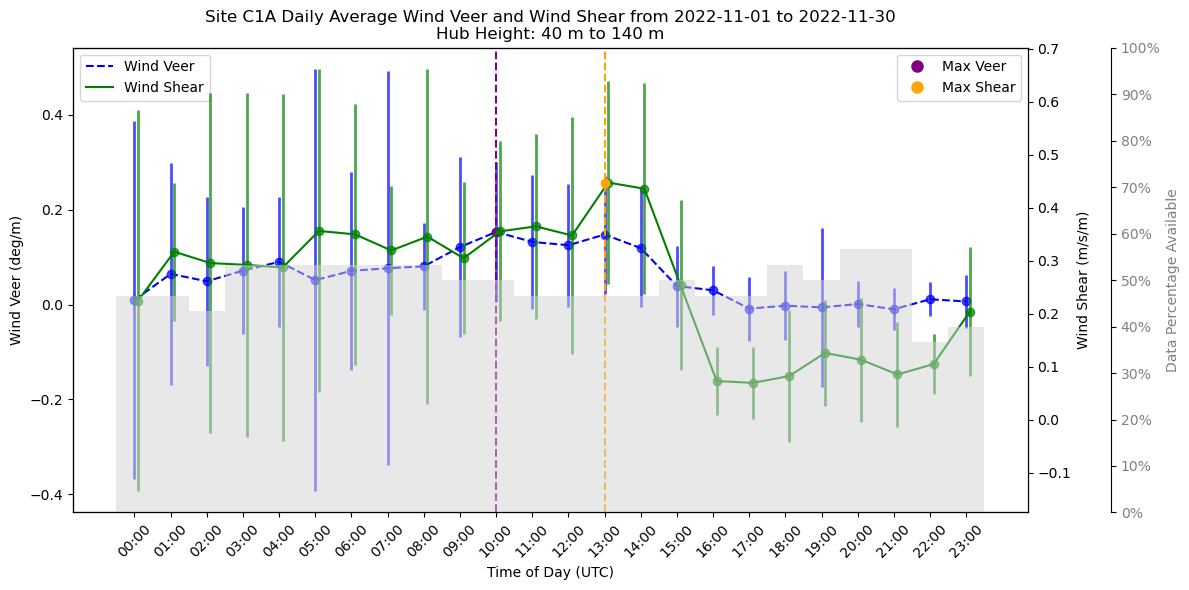


 DECEMBER 2022
Start Date:  2022-12-01 00:00:00
End Date:  2022-12-31 00:00:00
Maximum Wind Veer: 0.09999999999999987 deg/m at 09:00
Maximum Wind Shear: 0.36069295076408386 m/s/m at 11:00


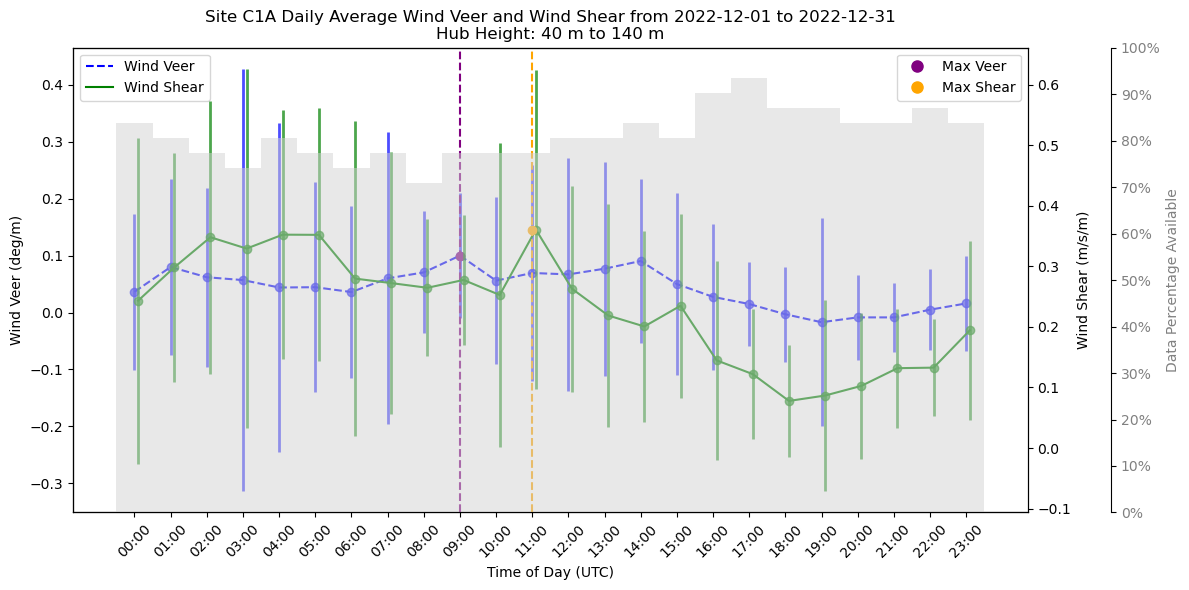


 JANUARY 2023
Start Date:  2023-01-01 00:00:00
End Date:  2023-01-31 00:00:00
Maximum Wind Veer: 0.12600000000000022 deg/m at 05:00
Maximum Wind Shear: 0.32633861042789214 m/s/m at 07:00


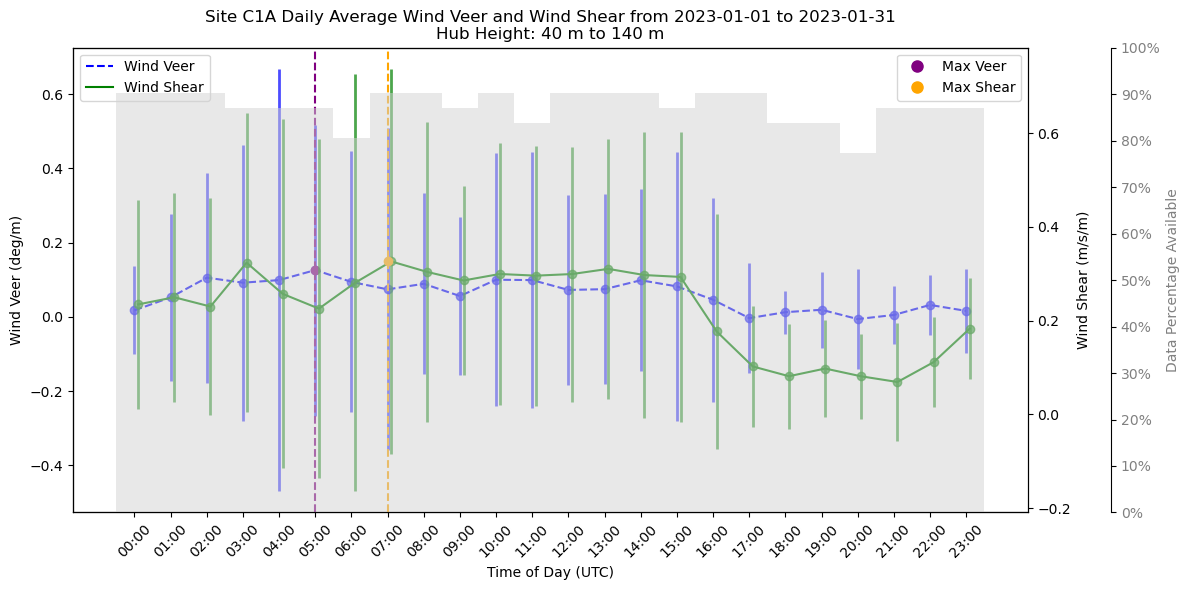


 FEBRUARY 2023
Start Date:  2023-02-01 00:00:00
End Date:  2023-02-28 00:00:00
Maximum Wind Veer: 0.08 deg/m at 14:00
Maximum Wind Shear: 0.4008686341919693 m/s/m at 05:00


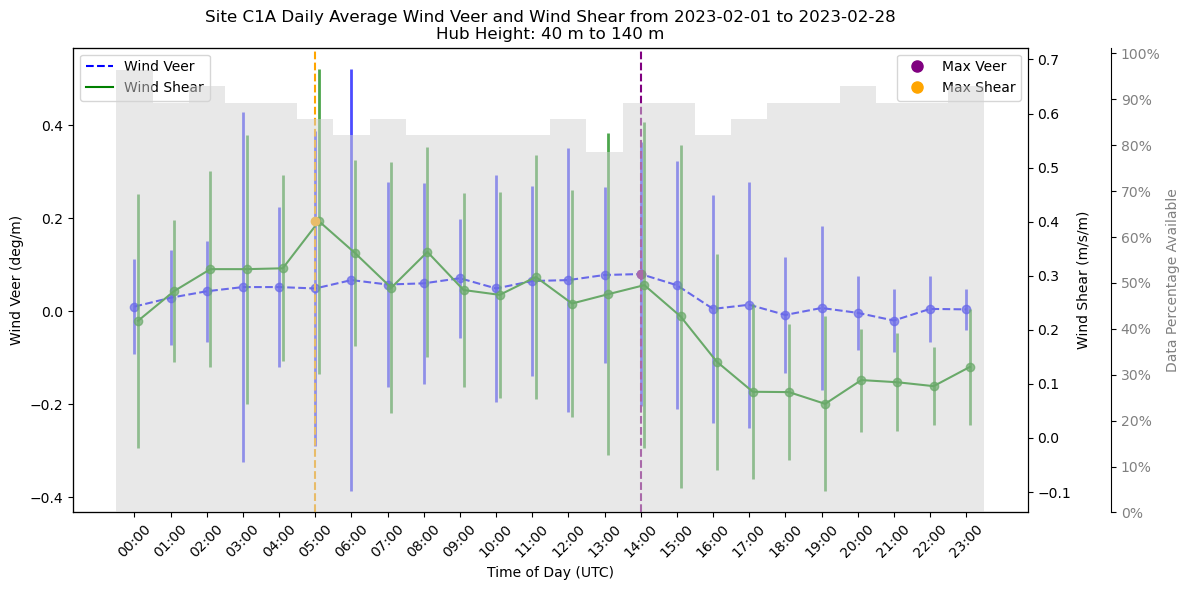


 MARCH 2023
Start Date:  2023-03-01 00:00:00
End Date:  2023-03-31 00:00:00
Maximum Wind Veer: 0.07599999999999994 deg/m at 13:00
Maximum Wind Shear: 0.35824927211423396 m/s/m at 09:00


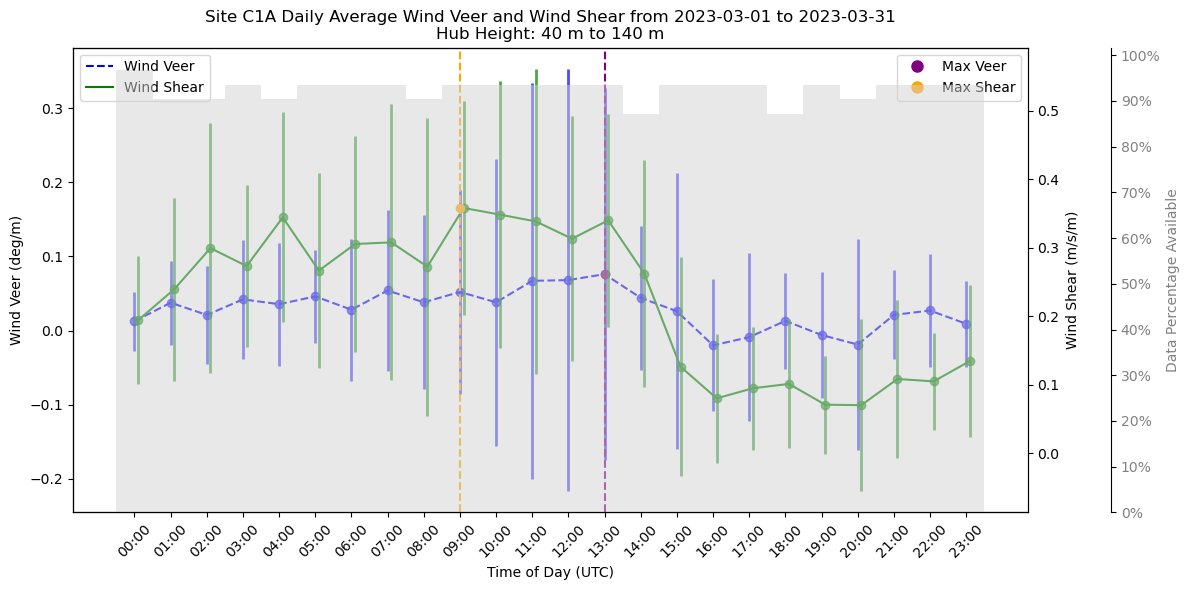


 APRIL 2023
Start Date:  2023-04-01 00:00:00
End Date:  2023-04-30 00:00:00
Maximum Wind Veer: 0.07949999999999989 deg/m at 13:00
Maximum Wind Shear: 0.3948238039836769 m/s/m at 13:00


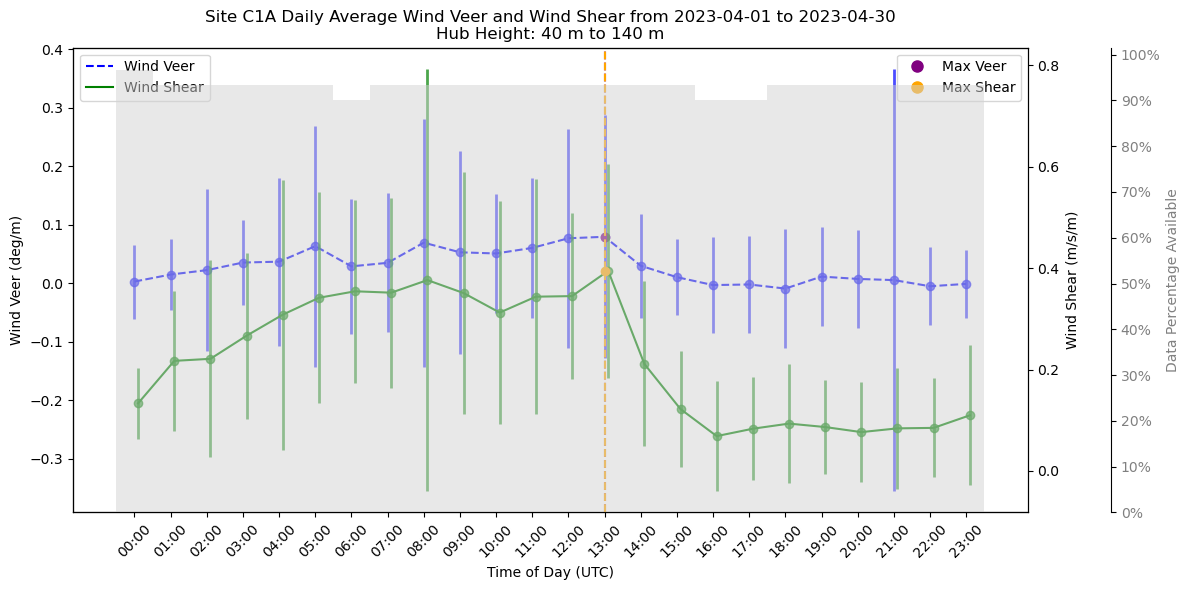


 MAY 2023
Start Date:  2023-05-01 00:00:00
End Date:  2023-05-31 00:00:00
Maximum Wind Veer: 0.14049999999999996 deg/m at 12:00
Maximum Wind Shear: 0.44404293021872815 m/s/m at 06:00


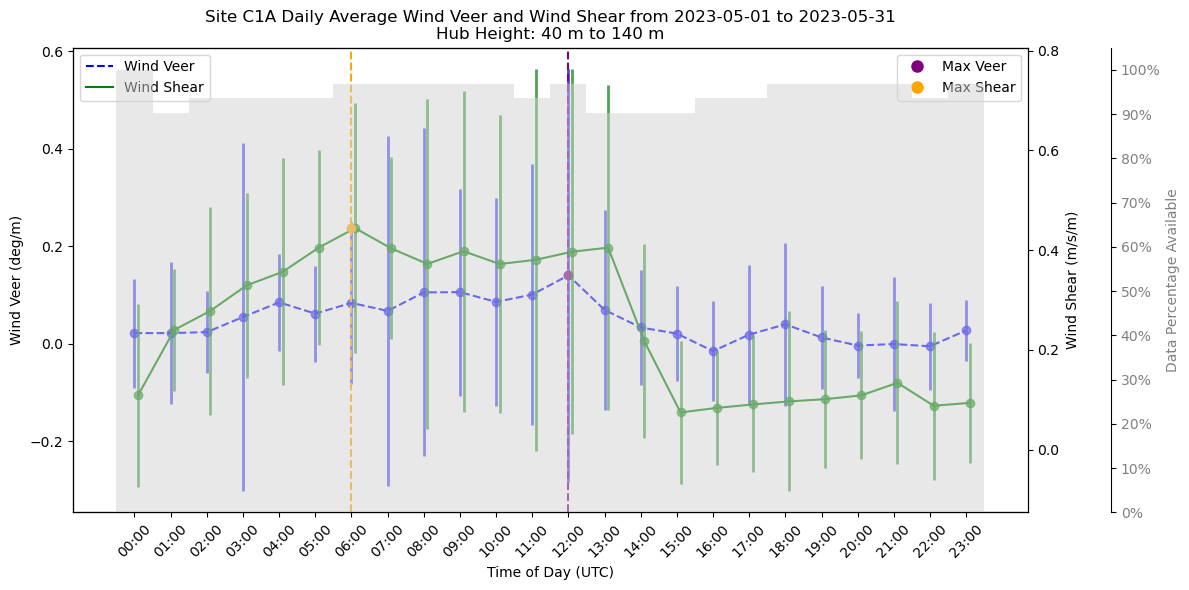


 JUNE 2023
Start Date:  2023-06-01 00:00:00
End Date:  2023-06-30 00:00:00
Maximum Wind Veer: 0.1225 deg/m at 11:00
Maximum Wind Shear: 0.4168371022621871 m/s/m at 11:00


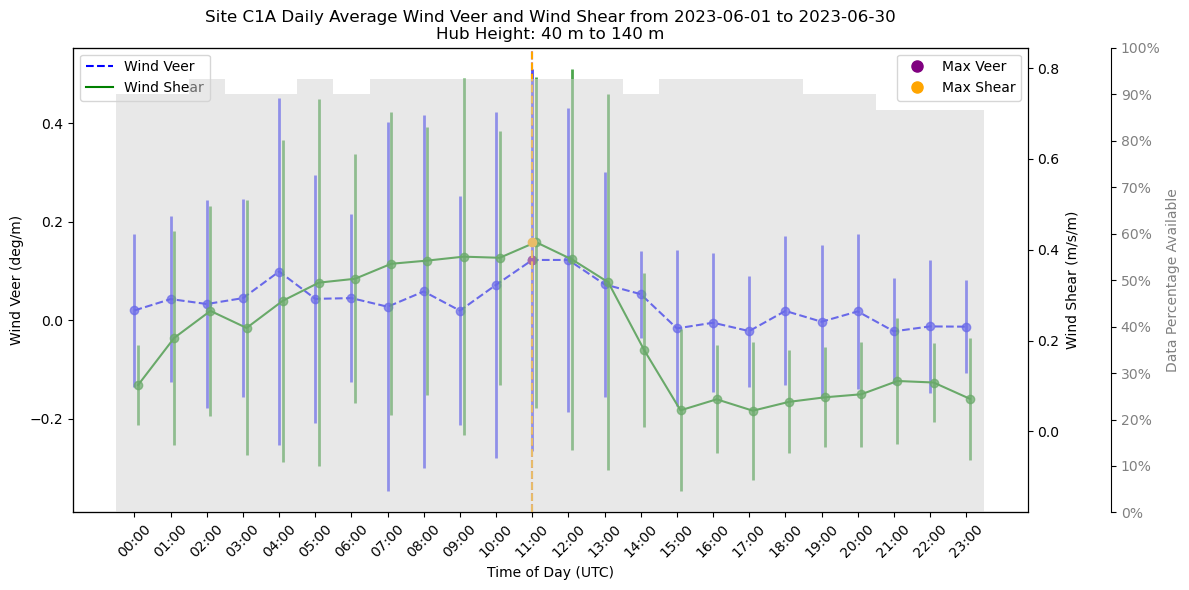


 JULY 2023
Start Date:  2023-07-01 00:00:00
End Date:  2023-07-31 00:00:00
Maximum Wind Veer: 0.07400000000000007 deg/m at 07:00
Maximum Wind Shear: 0.41320792668234474 m/s/m at 12:00


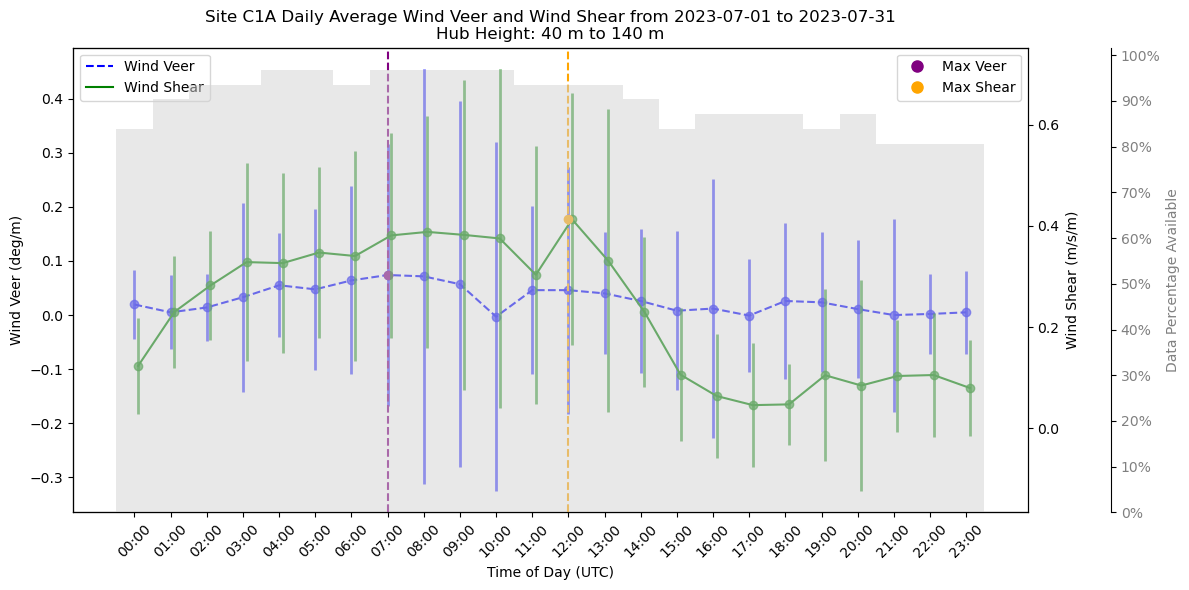


 AUGUST 2023
Start Date:  2023-08-01 00:00:00
End Date:  2023-08-31 00:00:00
Maximum Wind Veer: 0.09400000000000006 deg/m at 13:00
Maximum Wind Shear: 0.4319693707689197 m/s/m at 09:00


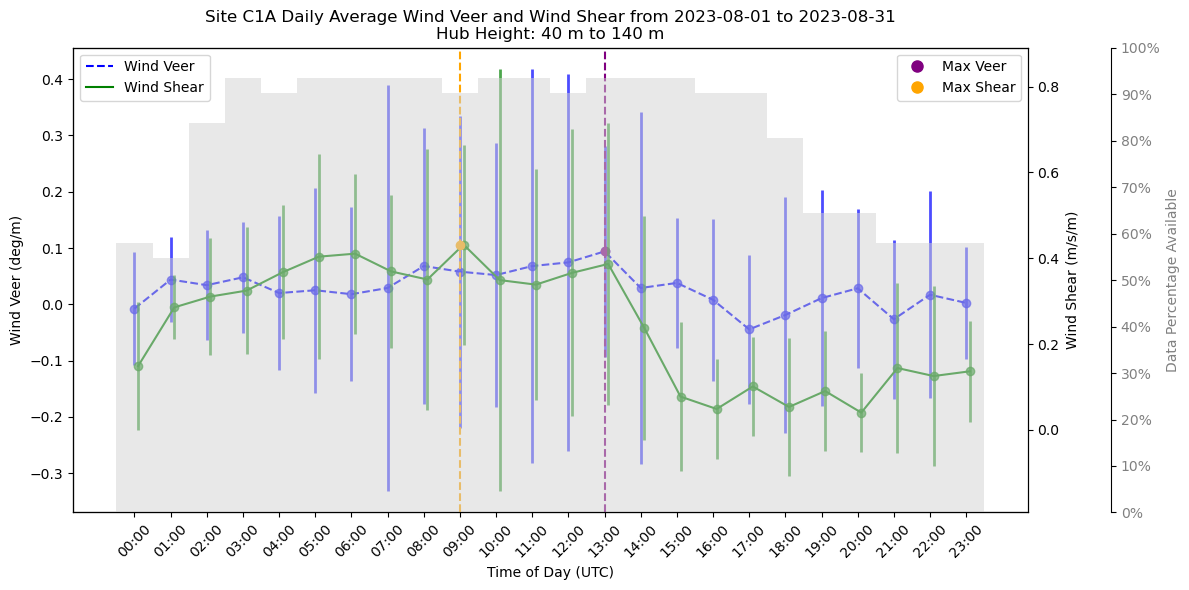


 SEPTEMBER 2023
Start Date:  2023-09-01 00:00:00
End Date:  2023-09-30 00:00:00
Maximum Wind Veer: 0.09550000000000011 deg/m at 08:00
Maximum Wind Shear: 0.45222175281545635 m/s/m at 13:00


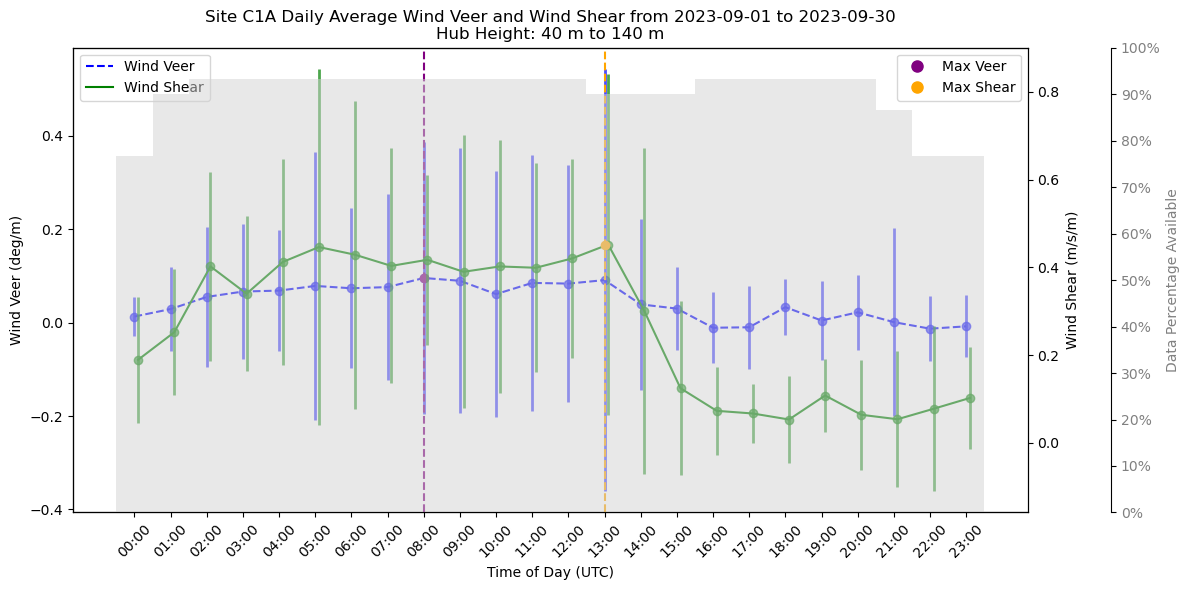


 OCTOBER 2023
Start Date:  2023-10-01 00:00:00
End Date:  2023-10-31 00:00:00
Maximum Wind Veer: 0.11 deg/m at 13:00
Maximum Wind Shear: 0.37324546755472876 m/s/m at 04:00


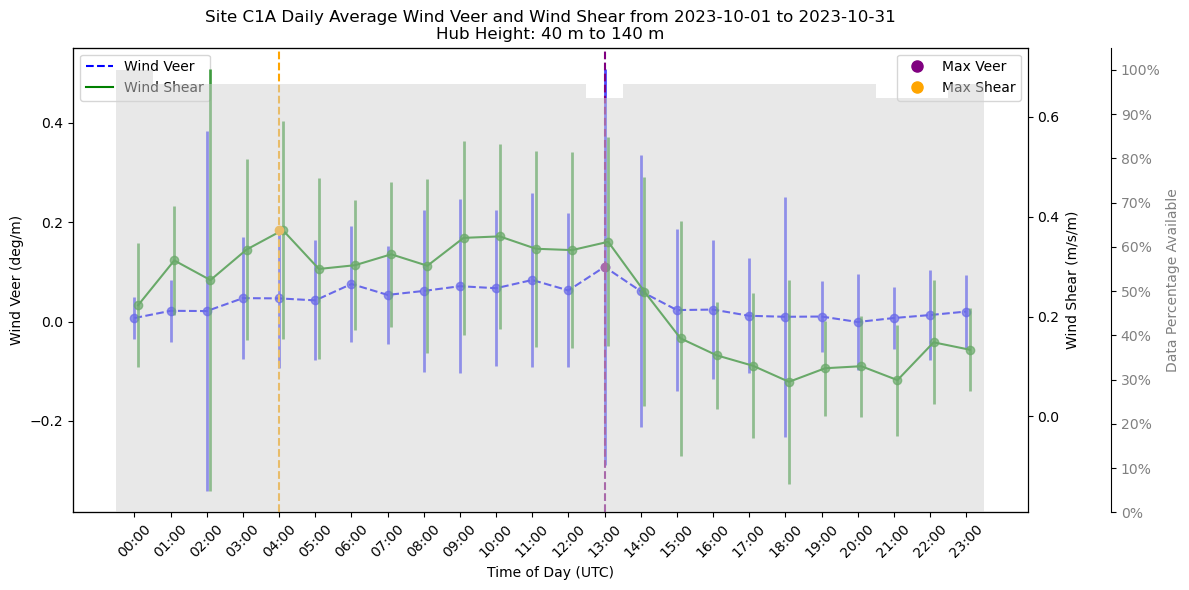


 NOVEMBER 2023
Start Date:  2023-11-01 00:00:00
End Date:  2023-11-30 00:00:00
Maximum Wind Veer: 0.09900000000000006 deg/m at 05:00
Maximum Wind Shear: 0.4048254674241921 m/s/m at 13:00


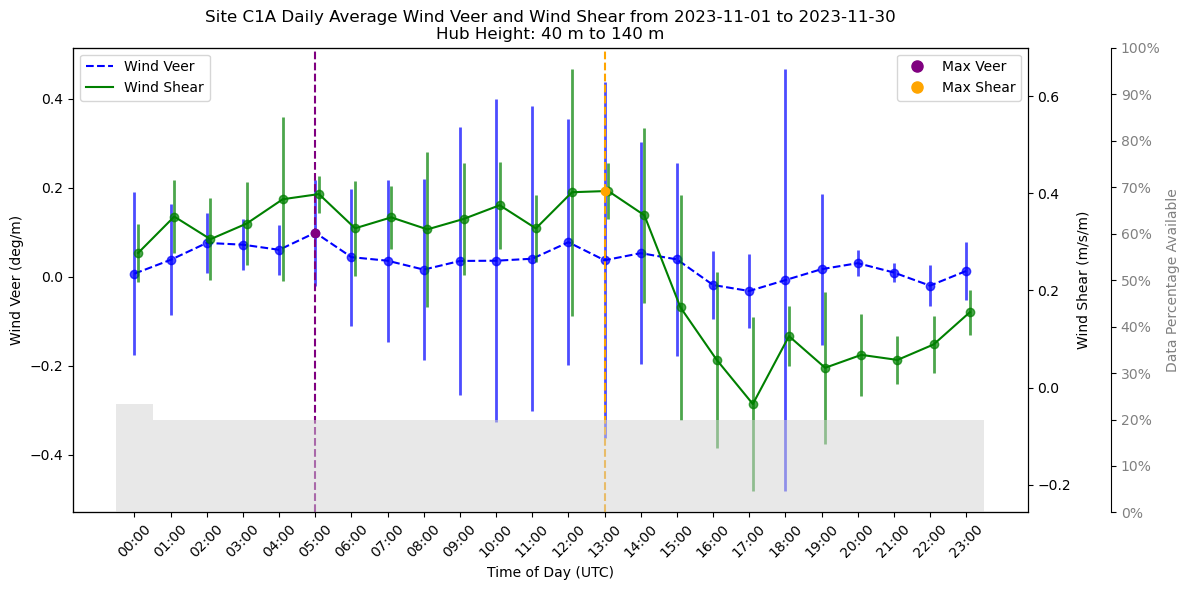

In [99]:
print("C1A DAILY MONTHLY AVERAGES")
print("Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not")

#for 11-2022
print("\n", "NOVEMEBER 2022")
start_date = datetime(2022, 11, 1)
end_date = datetime(2022, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 12-2022
print("\n", "DECEMBER 2022")
start_date = datetime(2022,12,1)
end_date = datetime(2022, 12, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 01-2023
print("\n", "JANUARY 2023")
start_date = datetime(2023,1,1)
end_date = datetime(2023, 1, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 02-2023
print("\n", "FEBRUARY 2023")
start_date = datetime(2023,2,1)
end_date = datetime(2023, 2, 28)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 03-2023
print("\n", "MARCH 2023")
start_date = datetime(2023,3,1)
end_date = datetime(2023, 3, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 04-2023
print("\n", "APRIL 2023")
start_date = datetime(2023,4,1)
end_date = datetime(2023, 4, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 05-2023
print("\n", "MAY 2023")
start_date = datetime(2023,5,1)
end_date = datetime(2023, 5, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 06-2023
print("\n", "JUNE 2023")
start_date = datetime(2023,6,1)
end_date = datetime(2023, 6, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 07-2023
print("\n", "JULY 2023")
start_date = datetime(2023,7,1)
end_date = datetime(2023, 7, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 08-2023
print("\n", "AUGUST 2023")
start_date = datetime(2023,8,1)
end_date = datetime(2023, 8, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 09-2023
print("\n", "SEPTEMBER 2023")
start_date = datetime(2023,9,1)
end_date = datetime(2023, 9, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 10-2023
print("\n", "OCTOBER 2023")
start_date = datetime(2023,10,1)
end_date = datetime(2023, 10, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 11-2023 (end date is later than A2 - can do full month)
print("\n", "NOVEMBER 2023")
start_date = datetime(2023,11,1)
end_date = datetime(2023, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

## Daily Averages for A2

A2 DAILY MONTHLY AVERAGES
Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not

 NOVEMEBER 2022
Start Date:  2022-11-11 00:00:00
End Date:  2022-11-30 00:00:00
Maximum Wind Veer: 0.31 deg/m at 14:00
Maximum Wind Shear: 0.5478855829301474 m/s/m at 11:00


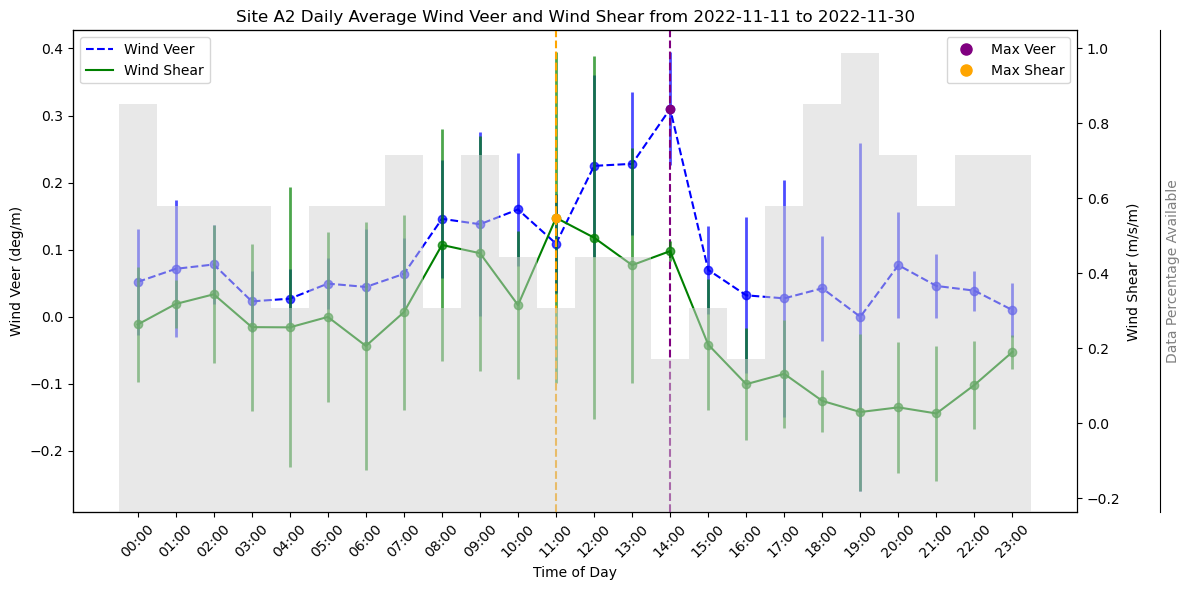


 DECEMBER 2022
Start Date:  2022-12-01 00:00:00
End Date:  2022-12-31 00:00:00
Maximum Wind Veer: 0.15600000000000008 deg/m at 04:00
Maximum Wind Shear: 0.3242700231941176 m/s/m at 02:00


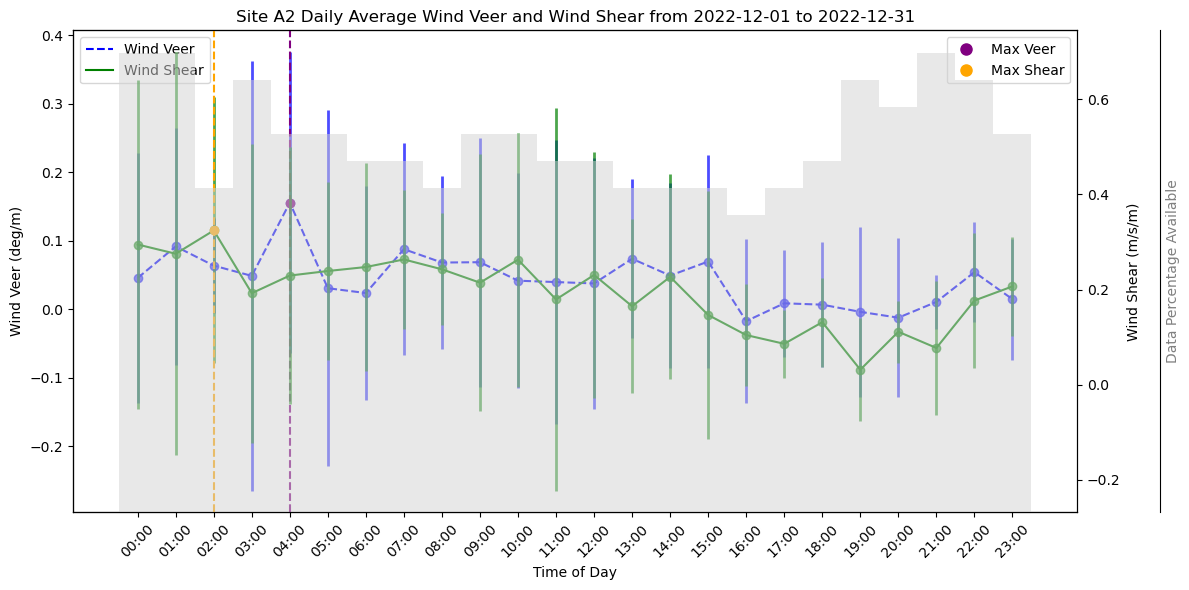


 JANUARY 2023
Start Date:  2023-01-01 00:00:00
End Date:  2023-01-31 00:00:00
Maximum Wind Veer: 0.1594999999999999 deg/m at 12:00
Maximum Wind Shear: 0.5890221053450362 m/s/m at 07:00


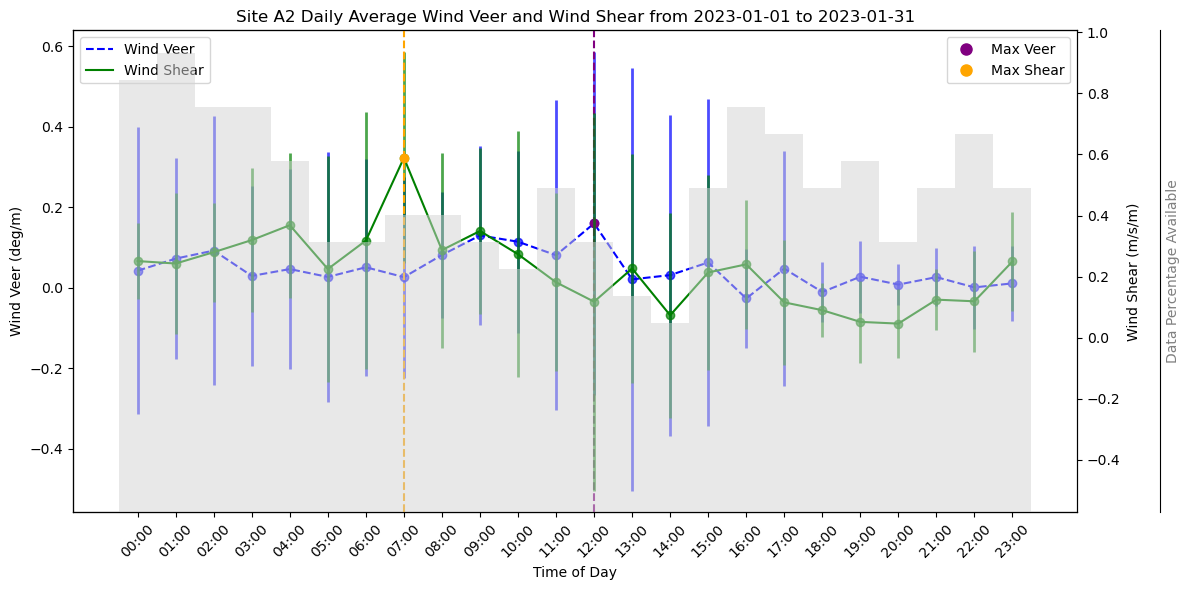


 FEBRUARY 2023
Start Date:  2023-02-01 00:00:00
End Date:  2023-02-28 00:00:00
Maximum Wind Veer: 0.11799999999999983 deg/m at 12:00
Maximum Wind Shear: 0.4544599372736912 m/s/m at 05:00


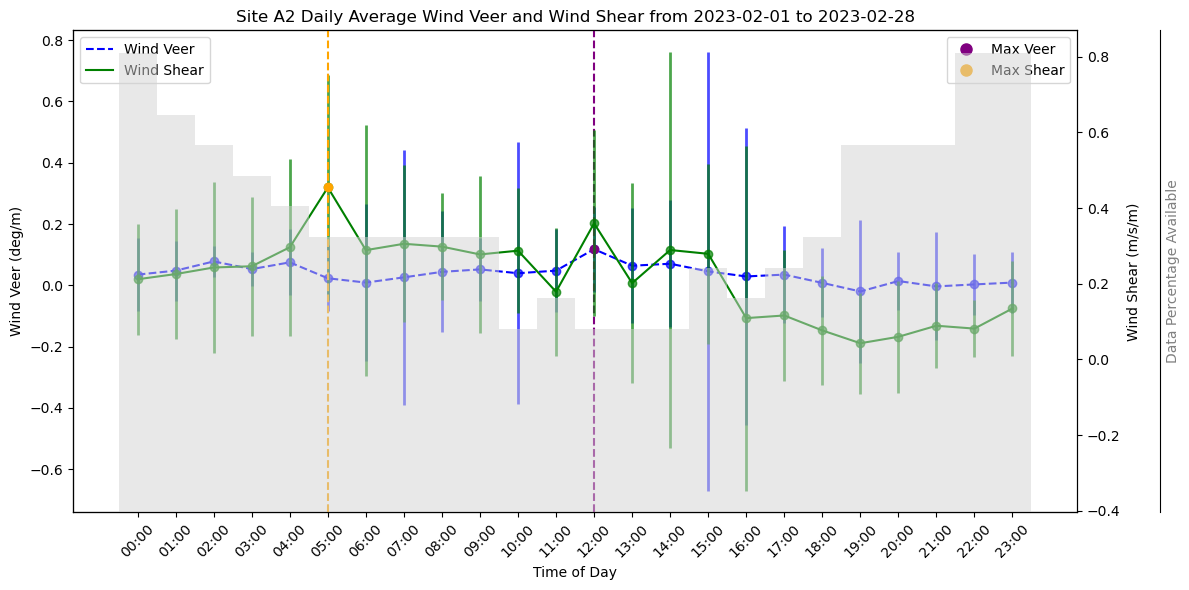


 MARCH 2023
Start Date:  2023-03-01 00:00:00
End Date:  2023-03-31 00:00:00
Maximum Wind Veer: 0.08299999999999996 deg/m at 08:00
Maximum Wind Shear: 0.30522086214981287 m/s/m at 03:00


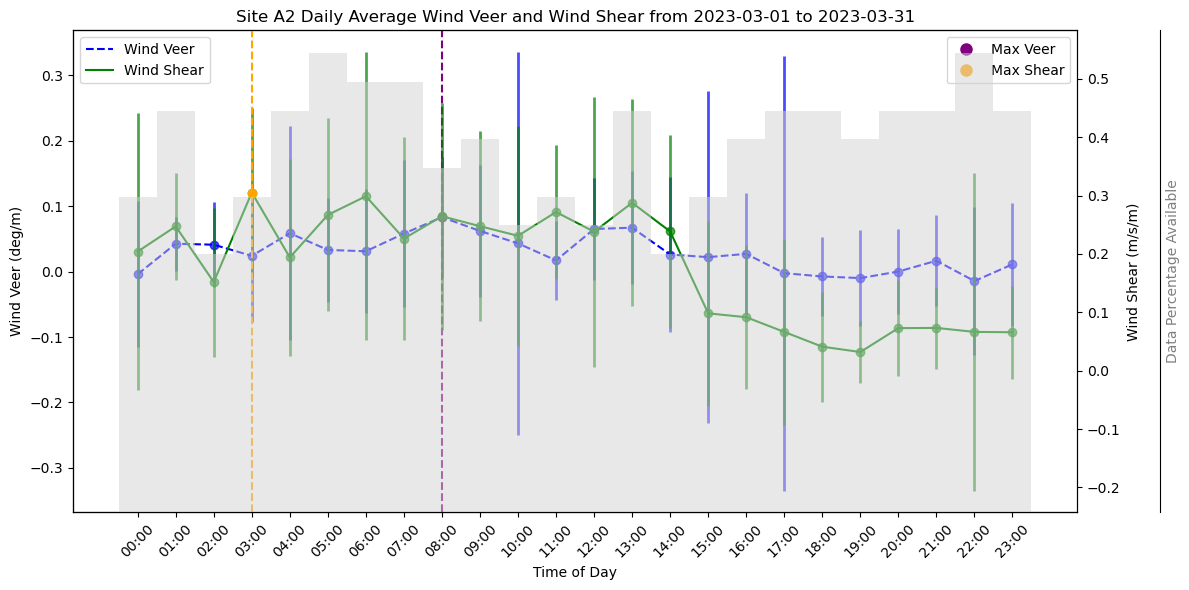


 APRIL 2023
Start Date:  2023-04-01 00:00:00
End Date:  2023-04-30 00:00:00
Maximum Wind Veer: 0.06400000000000006 deg/m at 14:00
Maximum Wind Shear: 0.3954214627881783 m/s/m at 13:00


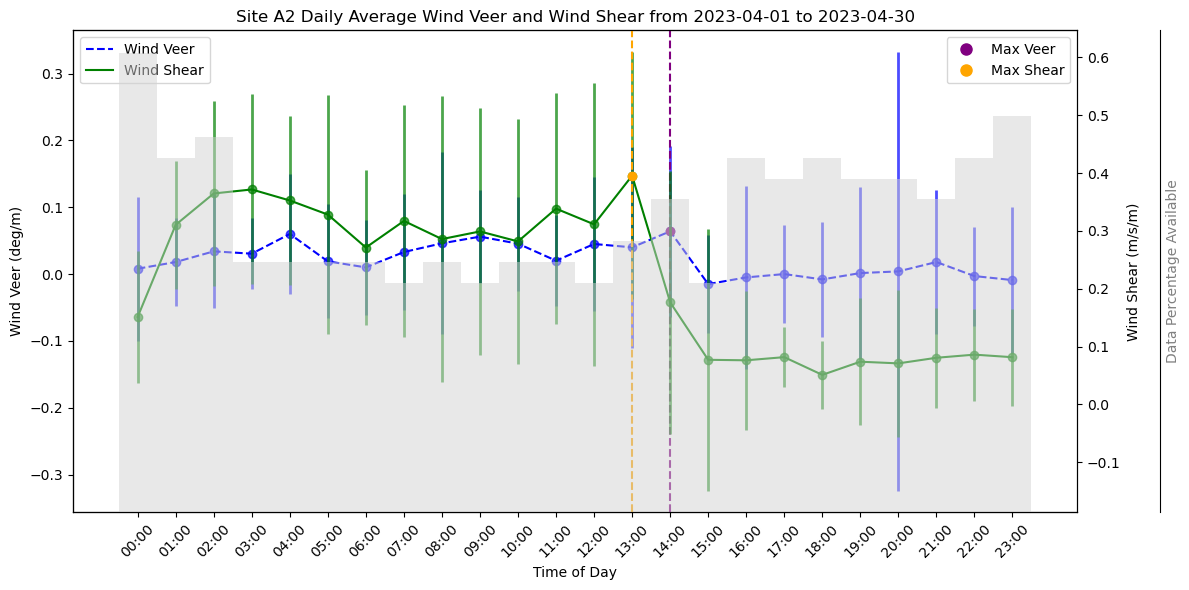


 MAY 2023
Start Date:  2023-05-01 00:00:00
End Date:  2023-05-31 00:00:00
Maximum Wind Veer: 0.12599999999999995 deg/m at 12:00
Maximum Wind Shear: 0.5365720181334476 m/s/m at 12:00


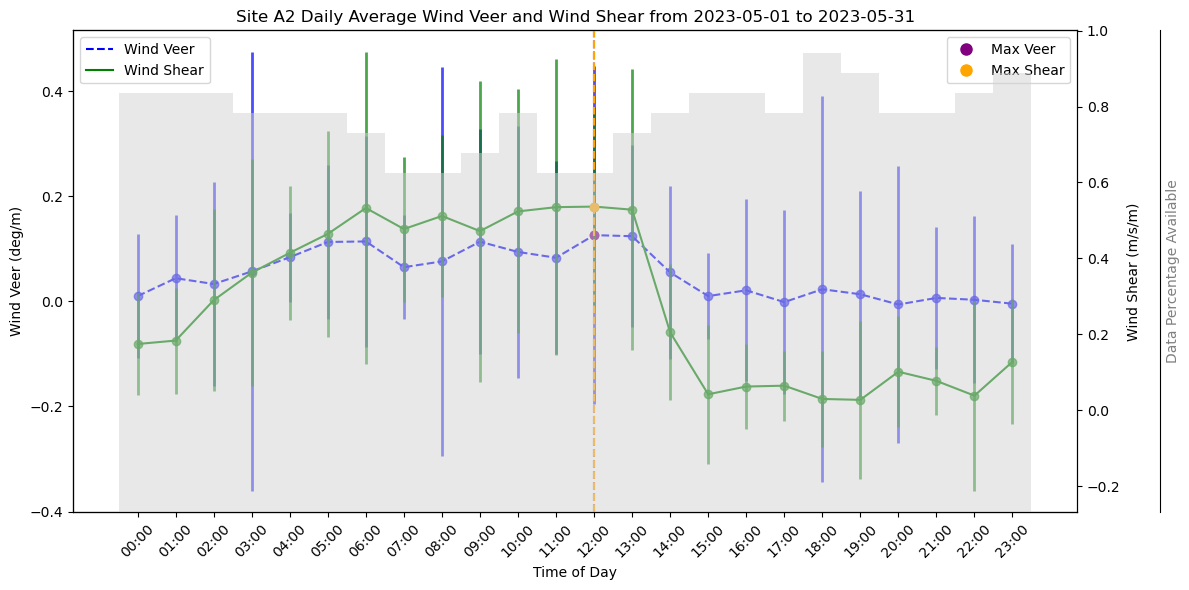


 JUNE 2023
Start Date:  2023-06-01 00:00:00
End Date:  2023-06-30 00:00:00
Maximum Wind Veer: 0.09350000000000008 deg/m at 12:00
Maximum Wind Shear: 0.5209473396312808 m/s/m at 10:00


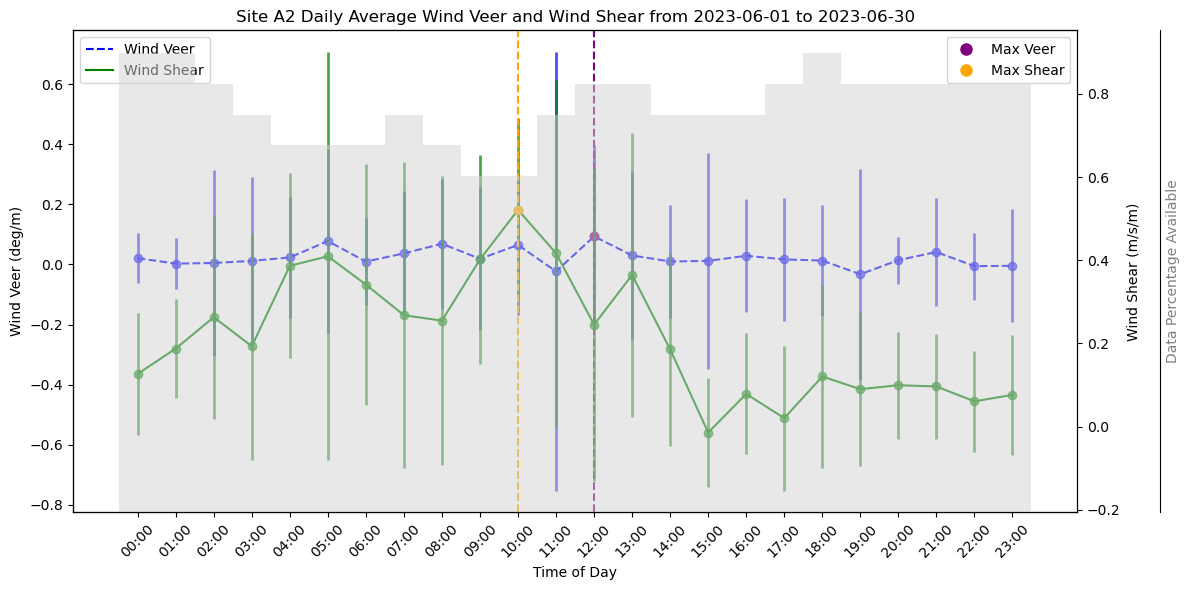


 JULY 2023
Start Date:  2023-07-01 00:00:00
End Date:  2023-07-31 00:00:00
Maximum Wind Veer: 0.08700000000000002 deg/m at 05:00
Maximum Wind Shear: 0.48131015507847313 m/s/m at 09:00


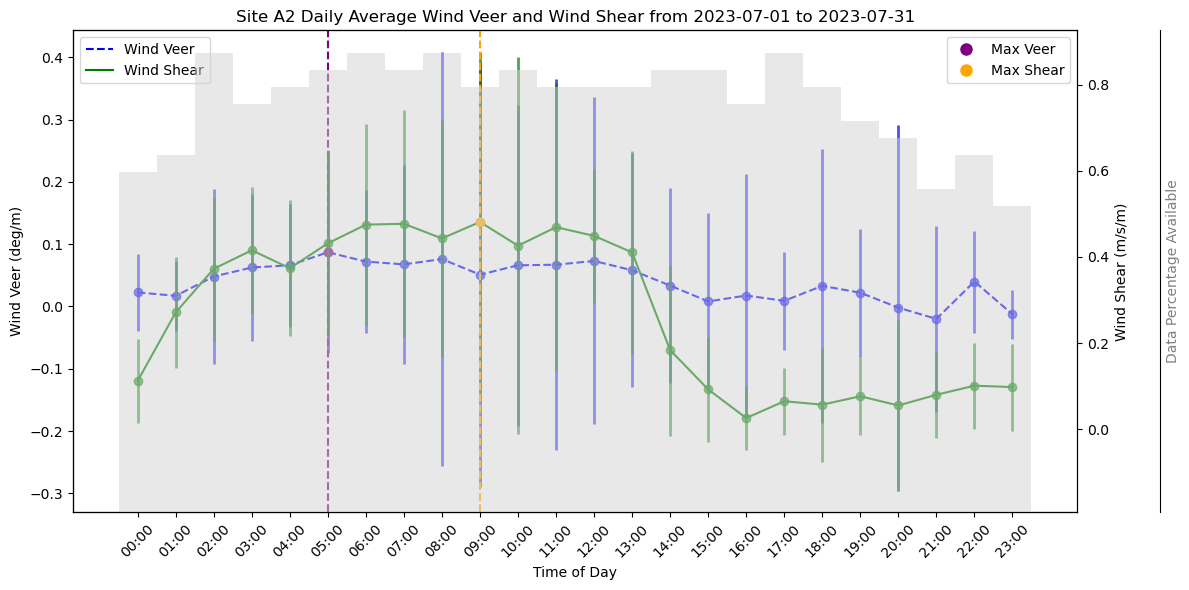


 AUGUST 2023
Start Date:  2023-08-01 00:00:00
End Date:  2023-08-31 00:00:00
Maximum Wind Veer: 0.1210000000000001 deg/m at 10:00
Maximum Wind Shear: 0.544901033736891 m/s/m at 08:00


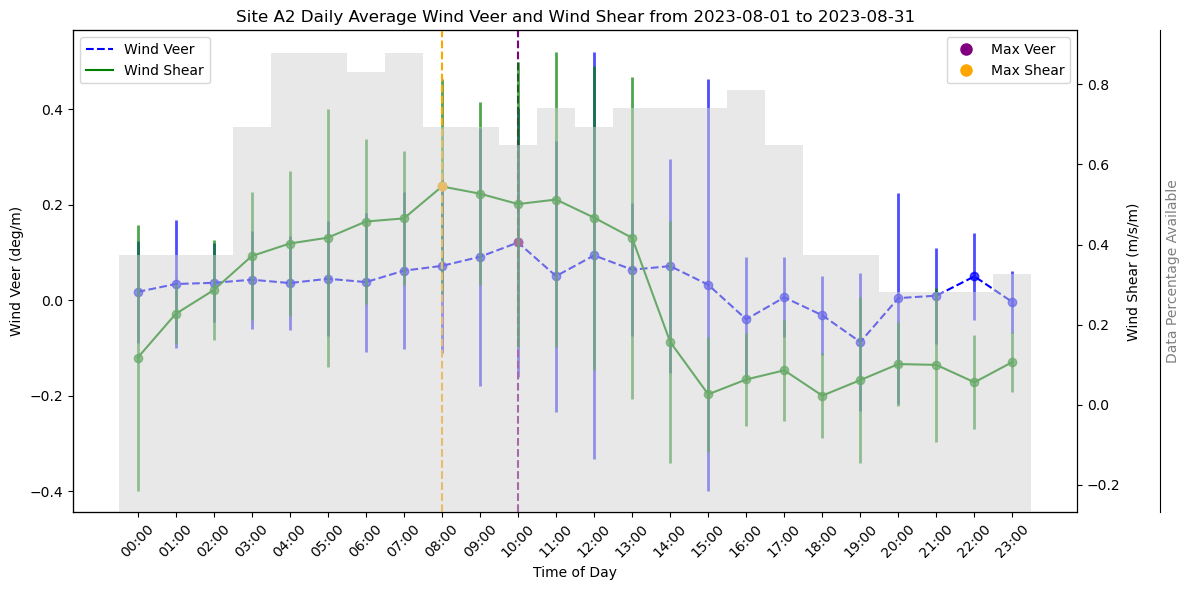


 SEPTEMBER 2023
Start Date:  2023-09-01 00:00:00
End Date:  2023-09-30 00:00:00
Maximum Wind Veer: 0.1269999999999999 deg/m at 12:00
Maximum Wind Shear: 0.6594492458455428 m/s/m at 11:00


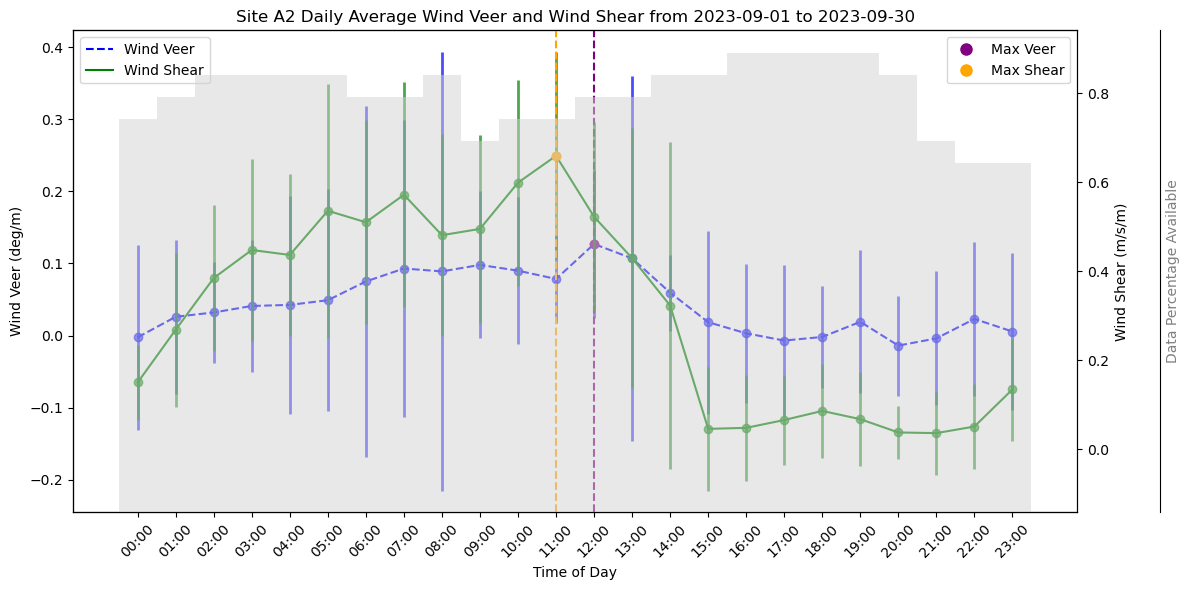


 OCTOBER 2023
Start Date:  2023-10-01 00:00:00
End Date:  2023-10-31 00:00:00
Maximum Wind Veer: 0.11300000000000011 deg/m at 13:00
Maximum Wind Shear: 0.49378917506376274 m/s/m at 13:00


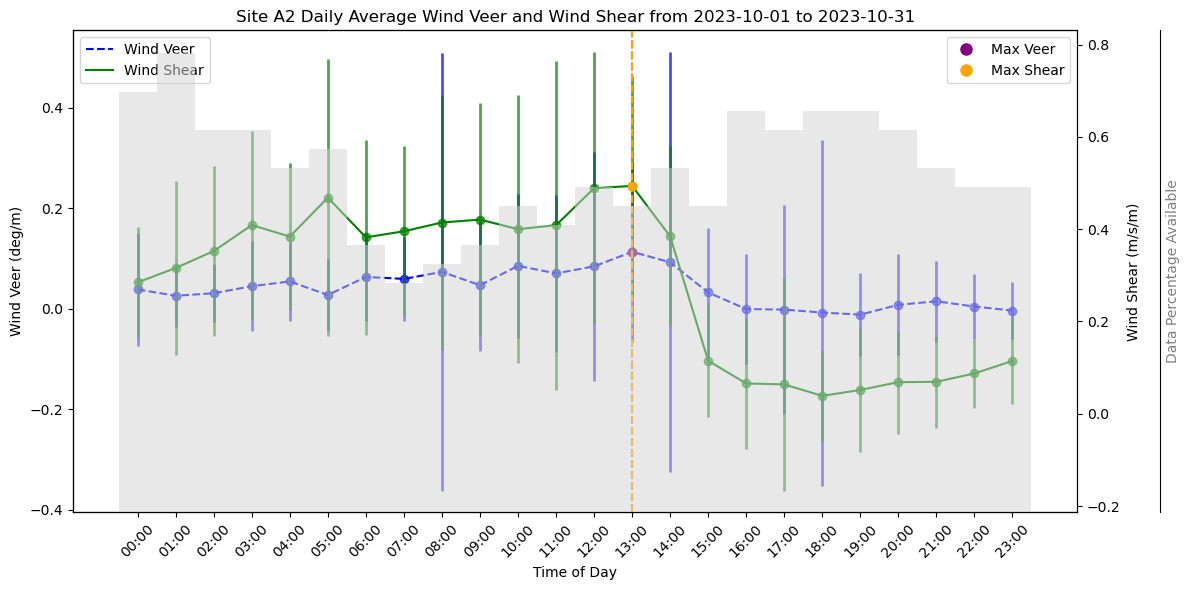


 NOVEMBER 2023
Start Date:  2023-11-01 00:00:00
End Date:  2023-11-06 00:00:00
Maximum Wind Veer: 0.5935000000000001 deg/m at 09:00
Maximum Wind Shear: 1.2648549310358592 m/s/m at 11:00


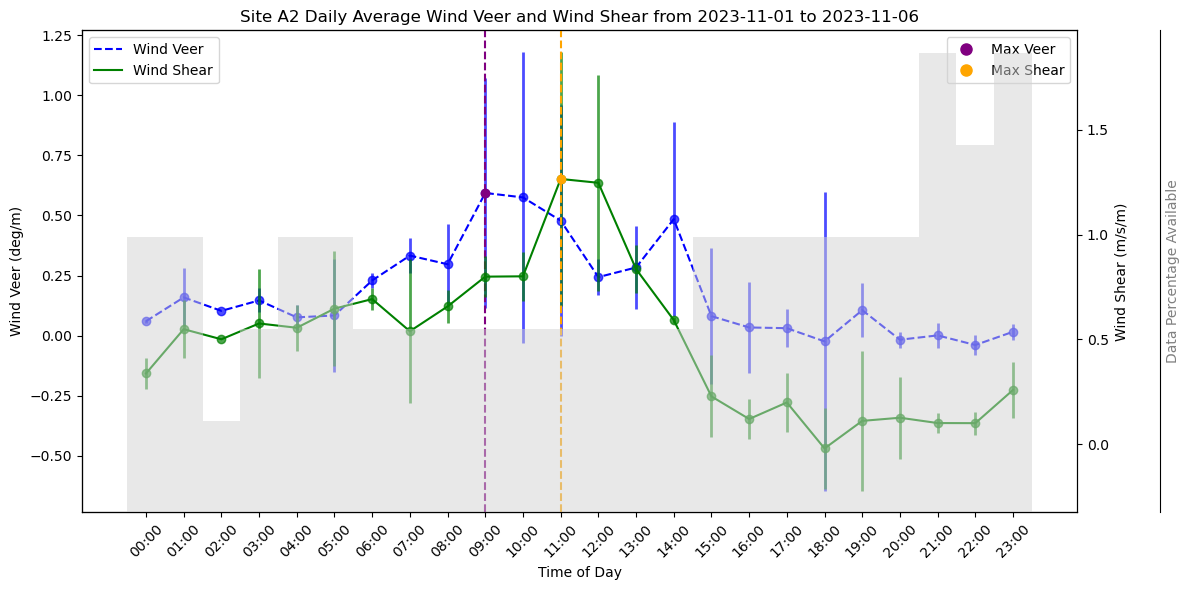

In [40]:
print("A2 DAILY MONTHLY AVERAGES")
print("Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not")

#for 11-2022
print("\n", "NOVEMEBER 2022")
start_date = datetime(2022, 11, 11)
end_date = datetime(2022, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 12-2022
print("\n", "DECEMBER 2022")
start_date = datetime(2022,12,1)
end_date = datetime(2022, 12, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 01-2023
print("\n", "JANUARY 2023")
start_date = datetime(2023,1,1)
end_date = datetime(2023, 1, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 02-2023
print("\n", "FEBRUARY 2023")
start_date = datetime(2023,2,1)
end_date = datetime(2023, 2, 28)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 03-2023
print("\n", "MARCH 2023")
start_date = datetime(2023,3,1)
end_date = datetime(2023, 3, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 04-2023
print("\n", "APRIL 2023")
start_date = datetime(2023,4,1)
end_date = datetime(2023, 4, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 05-2023
print("\n", "MAY 2023")
start_date = datetime(2023,5,1)
end_date = datetime(2023, 5, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 06-2023
print("\n", "JUNE 2023")
start_date = datetime(2023,6,1)
end_date = datetime(2023, 6, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 07-2023
print("\n", "JULY 2023")
start_date = datetime(2023,7,1)
end_date = datetime(2023, 7, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 08-2023
print("\n", "AUGUST 2023")
start_date = datetime(2023,8,1)
end_date = datetime(2023, 8, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 09-2023
print("\n", "SEPTEMBER 2023")
start_date = datetime(2023,9,1)
end_date = datetime(2023, 9, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 10-2023
print("\n", "OCTOBER 2023")
start_date = datetime(2023,10,1)
end_date = datetime(2023, 10, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 11-2023 (end date is later than A2 - can do full month)
print("\n", "NOVEMBER 2023")
start_date = datetime(2023,11,1)
end_date = datetime(2023, 11, 6)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAverageCompare(times1, wind_veer1, wind_shear1, start_date1, end_date1, 
                            times2, wind_veer2, wind_shear2, start_date2, end_date2):
    """
    Plots daily average wind veer and wind shear from two different time periods on the same graph.
    The x-axis represents the time of day (00:00 to 23:59, UTC), with error bars for both datasets.
    """
    def process_data(times, wind_veer, wind_shear, start_date, end_date):
        """Helper function to filter and process data."""
        # Convert times to datetime and localize to UTC if not already
        times = pd.to_datetime(times)
        if times.tzinfo is None:
            times = times.tz_localize('UTC')

        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        if start_date.tzinfo is None:
            start_date = start_date.tz_localize('UTC')
        if end_date.tzinfo is None:
            end_date = end_date.tz_localize('UTC')

        # Create DataFrame and filter by date range
        df = pd.DataFrame({
            'time': times,
            'wind_veer': wind_veer,
            'wind_shear': wind_shear
        })
        df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

        # Extract time of day
        df['time_of_day'] = df['time'].dt.strftime('%H:%M')

        # Create a complete index for all times of day (24 hours)
        all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

        # Group by time of day to calculate daily averages and standard deviations
        avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
        avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
        std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)
        std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

        return avg_veer, avg_shear, std_veer, std_shear, all_times

    # Process data for both time periods
    avg_veer1, avg_shear1, std_veer1, std_shear1, all_times1 = process_data(
        times1, wind_veer1, wind_shear1, start_date1, end_date1
    )
    avg_veer2, avg_shear2, std_veer2, std_shear2, all_times2 = process_data(
        times2, wind_veer2, wind_shear2, start_date2, end_date2
    )

    # Verify that both time periods cover the same time of day
    if not all_times1.equals(all_times2):
        raise ValueError("The two time periods must cover the same time of day range.")

    # Plot the data
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Wind Veer for both time periods
    ax1.errorbar(
        avg_veer1.index, avg_veer1.values, yerr=std_veer1.values, 
        fmt='o', color='blue', alpha=0.7, elinewidth=1.5, label='Veer Period 1'
    )
    ax1.errorbar(
        avg_veer2.index, avg_veer2.values, yerr=std_veer2.values, 
        fmt='o', color='red', alpha=0.7, elinewidth=1.5, label='Veer Period 2'
    )
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Wind Shear for both time periods
    ax2 = ax1.twinx()
    ax2.errorbar(
        avg_shear1.index, avg_shear1.values, yerr=std_shear1.values, 
        fmt='o', color='green', alpha=0.7, elinewidth=1.5, label='Shear Period 1'
    )
    ax2.errorbar(
        avg_shear2.index, avg_shear2.values, yerr=std_shear2.values, 
        fmt='o', color='orange', alpha=0.7, elinewidth=1.5, label='Shear Period 2'
    )
    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add title and legends
    ax1.set_title(f'Comparison of Daily Average Wind Veer and Shear\n'
                  f'Period 1: {start_date1.date()} to {end_date1.date()} vs. '
                  f'Period 2: {start_date2.date()} to {end_date2.date()}')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
